### Audio Data preprocessing 

In [1]:
import os
import sys
import tqdm

# Get the waveform from each video
from utils.file_format import convert_mp4_to_wav

path_to_audio = './../dataset_raw/Intro/Audio/'
path_to_video = './../dataset_raw/Intro/Video/'

for video in os.listdir(path_to_video):
    convert_mp4_to_wav(path_to_video + video, path_to_audio + video[:-4] + '.wav')


MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro9.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro2.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro0.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro6.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro8.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro10.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro5.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro1.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro3.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro7.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro4.wav


MoviePy - Done.
MoviePy - Writing audio in ./../dataset_raw/Intro/Audio/Intro11.wav


MoviePy - Done.


### Exploratory Audio Data Analysis

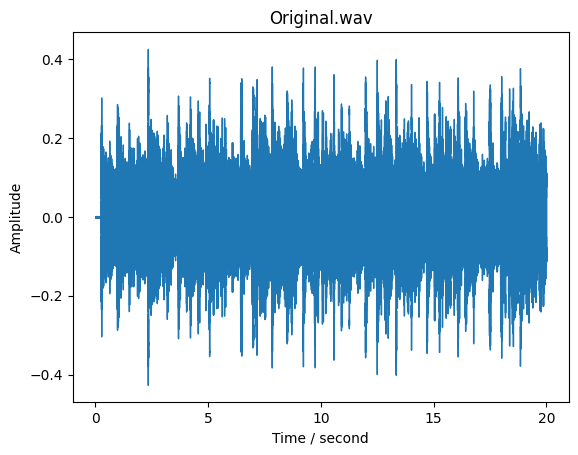

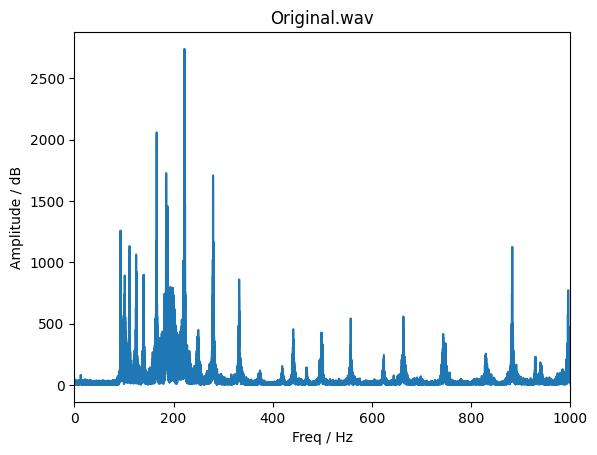

In [2]:
# Display original audio and features
from utils.data_visualization import plot_waveform, plot_frquency
import librosa
from IPython.display import Audio
import pandas as pd

audio_filepath = './../dataset_raw/Original.wav'
sample = 'Original.wav'

y, sr = librosa.load(audio_filepath, duration=20)
fig = plot_waveform(y, sr, sample)
plot_frquency(y, sr, sample)

# Playback
Audio(data=y, rate=sr)


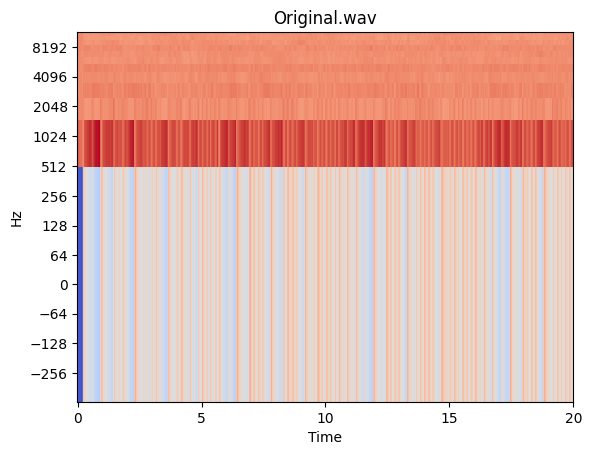

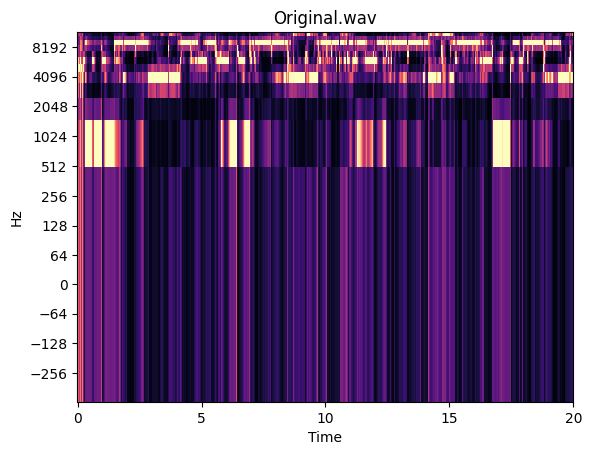

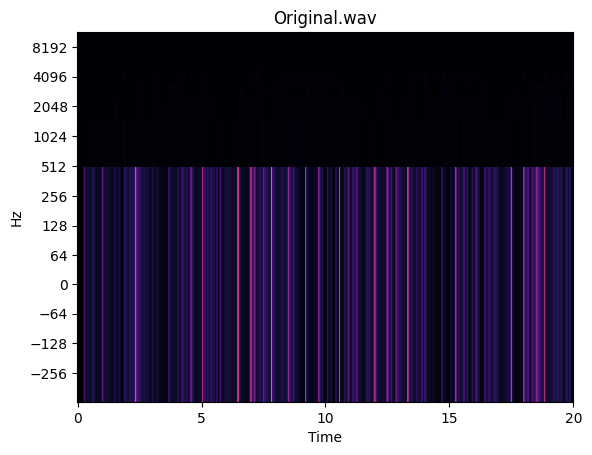

In [3]:
# Original Acoustic Features
from utils.data_visualization import plot_chromagram, plot_mel_spectrogram, plot_mfcc

plot_mfcc(y, sr, sample)
plot_chromagram(y, sr, sample)
plot_mel_spectrogram(y, sr, sample)

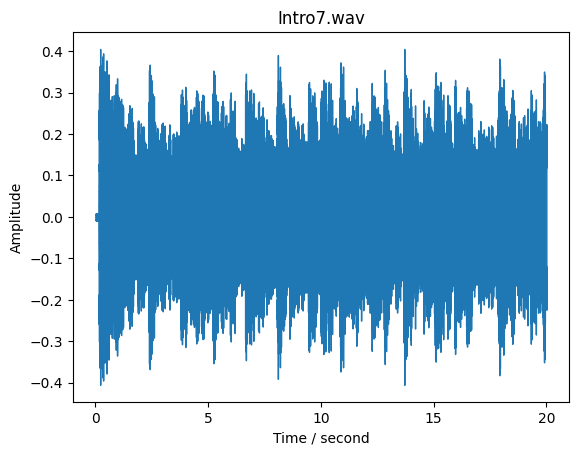

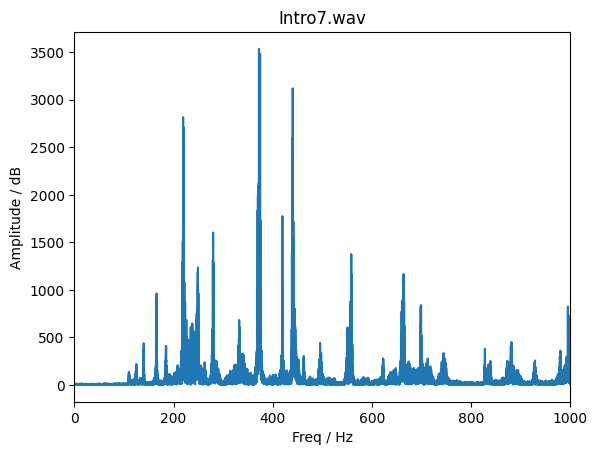

In [4]:
# Display sample audio
audio_filepath = './../dataset_raw/Intro/Audio/'
audio_files = os.listdir(audio_filepath)
audio_files = pd.DataFrame(audio_files)

sample = audio_files.sample(n=1)
sample = sample[0].values[0]

sample_path = audio_filepath + sample

y, sr = librosa.load(sample_path, duration=20)
fig = plot_waveform(y, sr, sample)
plot_frquency(y, sr, sample)

Audio(data=y, rate=sr)

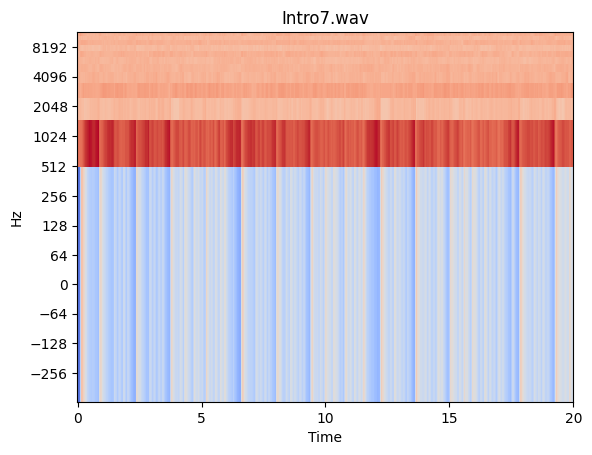

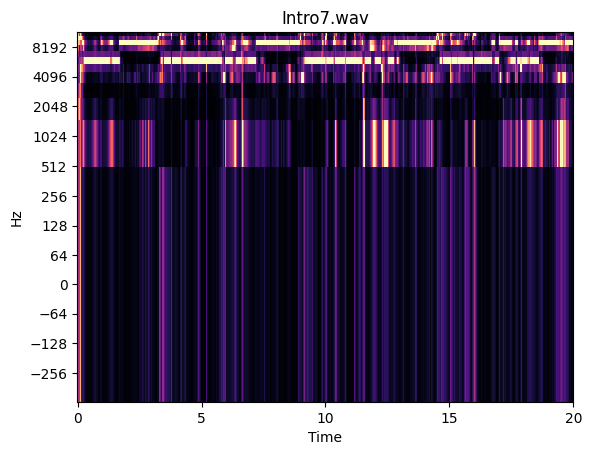

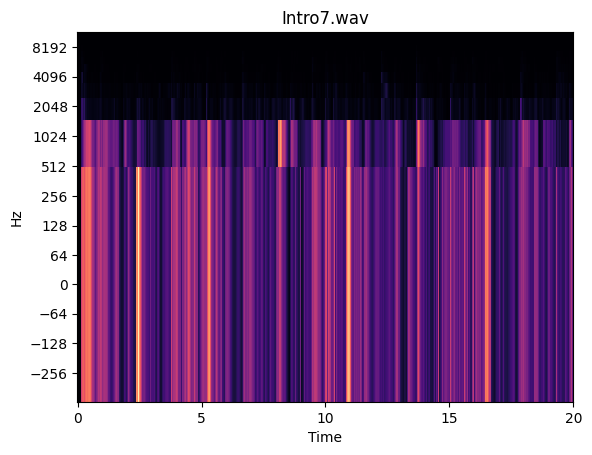

In [5]:
# Plot Audio Features

plot_mfcc(y, sr, sample)
plot_chromagram(y, sr, sample)
plot_mel_spectrogram(y, sr, sample)

In [6]:
# Generate Feature Matrix for Audio
from utils.audio_feature_extraction import generate_feature_matrix, get_chromagram, get_melspectrogram, get_mfccs
import numpy as np

audio_filepath = './../dataset_raw/Intro/Audio/'

os.listdir(audio_filepath)

features = []
for waveform in os.listdir(audio_filepath):
    waveform_path = audio_filepath + waveform

    y, sr = librosa.load(waveform_path, sr=32000, duration=23)
    df_mfccs, mfccs = get_mfccs(y, sr)

    features.append(df_mfccs.values)


In [7]:
# Generate Audio Features for Anchor and Negative instance

# Anchor Features 
anchor_path = './../dataset_raw/Original.wav'

y, sr = librosa.load(anchor_path, sr=32000, duration=23)
df_mfccs, mfccs = get_mfccs(y, sr)

anchor_feature = df_mfccs.values

# Negative Features 
negative_path = './../dataset_raw/Negative.wav'

y, sr = librosa.load(negative_path, sr=32000, duration=23)
df_mfccs, mfccs = get_mfccs(y, sr)

negative_feature = df_mfccs.values



In [8]:
# Convert matrices to numpy arrays
features = np.asanyarray(features)
negative_feature = np.asanyarray(negative_feature)
anchor_feature = np.asanyarray(anchor_feature)

# Reshape Audio Features
features = np.reshape(features, (features.shape[0], -1))
anchor_feature_matrix = np.reshape(anchor_feature, -1)
negative_feature_matrix = np.reshape(negative_feature, -1)

print(anchor_feature.shape)
print(negative_feature.shape)
print(features.shape)



(12, 12)
(12, 12)
(12, 144)


In [9]:
# Generate Pairs
pairs = []
labels = []

for idx, feature in enumerate(features):
    
    # Positive Pair
    if(idx % 2 == 0):
        pairs.append([anchor_feature_matrix, feature])
        labels.append(1)
    
    # Negative Pair
    else:
        pairs.append([anchor_feature_matrix, negative_feature_matrix])
        labels.append(0)


X = pairs
Y = labels

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)

X_train = np.asanyarray(X_train, dtype=np.float32)
y_train = np.asanyarray(y_train, dtype=np.float32)

X_test = np.asanyarray(X_test, dtype=np.float32)
y_test = np.asanyarray(y_test, dtype=np.float32)

### Model Creation
References for the model: 
+ https://github.com/sudharsan13296/Hands-On-Meta-Learning-With-Python/blob/master/02.%20Face%20and%20Audio%20Recognition%20using%20Siamese%20Networks/2.5%20Audio%20Recognition%20using%20Siamese%20Network.ipynb
+ https://keras.io/examples/vision/siamese_contrastive/

In [11]:
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import RMSprop

def build_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)

2023-05-03 10:39:57.591284: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 10:39:57.611948: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 10:39:57.612228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 10:39:58.134941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
# Shape inputs

input_dim = X_train.shape[2:]

audio_a = Input(shape=input_dim)
audio_b = Input(shape=input_dim)


In [13]:
# Create base network

base_network = build_base_network(input_dim)

feat_vecs_a = base_network(audio_a)
feat_vecs_b = base_network(audio_b)

2023-05-03 10:39:58.742017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-03 10:39:58.758536: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
# Define euclidean distances

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [15]:
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [16]:
epochs = 10
rms = RMSprop()

In [17]:
model = Model([audio_a, audio_b], output)

In [18]:
# Define loss function

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [19]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)

In [20]:
# Train model

history = model.fit([X_train[:,0], X_train[:,1]], y_train, validation_split=.20,
            batch_size=128, epochs=20)

Epoch 1/20
1/1 [==============================] - 1s 588ms/step - loss: 0.4670 - val_loss: 0.4796
Epoch 2/20
1/1 [==============================] - 0s 21ms/step - loss: 0.4410 - val_loss: 0.4743
Epoch 3/20
1/1 [==============================] - 0s 19ms/step - loss: 0.4266 - val_loss: 0.4695
Epoch 4/20
1/1 [==============================] - 0s 20ms/step - loss: 0.4304 - val_loss: 0.4657
Epoch 5/20
1/1 [==============================] - 0s 17ms/step - loss: 0.3998 - val_loss: 0.4608
Epoch 6/20
1/1 [==============================] - 0s 17ms/step - loss: 0.4019 - val_loss: 0.4552
Epoch 7/20
1/1 [==============================] - 0s 18ms/step - loss: 0.3919 - val_loss: 0.4506
Epoch 8/20
1/1 [==============================] - 0s 17ms/step - loss: 0.3673 - val_loss: 0.4464
Epoch 9/20
1/1 [==============================] - 0s 17ms/step - loss: 0.3758 - val_loss: 0.4431
Epoch 10/20
1/1 [==============================] - 0s 17ms/step - loss: 0.3790 - val_loss: 0.4400
Epoch 11/20
1/1 [===========

In [21]:
# Accuracy Calculation

def compute_accuracy(y_true, y_pred):

    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

In [23]:
# Results for model

results = model.evaluate([X_test[:,0],X_test[:,1]], y_test, batch_size=128)

y_pred_train = model.predict([X_train[:,0], X_train[:,1]])
train_accuracy = compute_accuracy(y_train, y_pred_train)

y_pred_test = model.predict([X_test[:,0], X_test[:,1]])
test_accuracy = compute_accuracy(y_test, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(results, train_accuracy, test_accuracy))


1/1 [==============================] - 0s 12ms/step
Loss = 0.3942943513393402, Train Accuracy = 0.5 Test Accuracy = 0.5


In [26]:
print(y_test)
print(y_pred_test.ravel())

[1. 0. 1. 1. 0. 0.]
[0.15874217 0.1226944  0.12999557 0.12113062 0.1226944  0.1226944 ]


In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])

KeyError: 'accuracy'